# Generative Adverserial Networks in PyTorch

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adverserial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling

> Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset. - [Source](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

While there are many approaches used for generative modeling, a Generative Adverserial Network takes the following approach: 

![GAN Flowchart](https://i.imgur.com/6NMdO9u.png)

There are two neural networks: a *Generator* and a *Discriminator*. The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator). Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs. This rather simple approach can lead to some astounding results. The following images ([source](https://machinelearningmastery.com/resources-for-getting-started-with-generative-adversarial-networks/)), for instances, were all generated using GANs:

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Example-of-Photorealistic-Human-Faces-Generated-by-a-GAN.png" alt="gans_results" width="480">


GANs however, can be notoriously difficult to train, and are extremely sensitive to hyperparameters, activation functions and regularization. 

In this tutorial, we'll train a GAN to generate images of handwritten digits similar to those from the MNIST database.

<img src="https://i.imgur.com/CAYnuo1.jpg" width="360" >


* Define the problem statement
* Load the data (with transforms and normalization)
    * Denormalize for visual inspection of samples
* Define the Discriminator network
    * Study the activation function: Leaky ReLU
* Define the Generator network
    * Explain the output activation function: TanH
    * Look at some sample outputs
* Define losses, optimizers and helper functions for training
    * For discriminator
    * For generator
* Train the model
    * Save intermediate generated images to file
* Look at some outputs
* Save the models
* Commit to Jovian.ml

## Loading the Data

In [35]:
import torch
import torchvision 
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose

In [36]:
mnist = MNIST(root="data/",train=True, download=True, transform = Compose([ToTensor(), Normalize(mean=(0.5,),std=(0.5,))]))

In [37]:
img, label = mnist[0]
print(label)
print(img[:,10:15,10:15])
print(torch.min(img), torch.max(img))

5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])
tensor(-1.) tensor(1.)


To view the images, we need to denormalize them. So as to bring them back to the 0-1 range. 

In [38]:
def denorm(x):
    out = (x+1)/2
    return out.clamp(0,1)

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

Label:  5


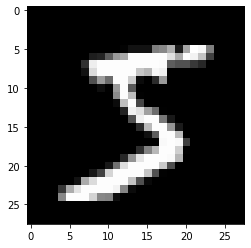

In [40]:
img_denorm = denorm(img)
plt.imshow(img_denorm[0],cmap='gray')
print("Label: ", label)

#### Making DataLaoder

In [41]:
from torch.utils.data import DataLoader

In [42]:
batch_size = 100

data_loader = DataLoader(mnist, batch_size = batch_size, shuffle=True)

torch.Size([100, 1, 28, 28])
torch.Size([1, 28, 28])
tensor(7)


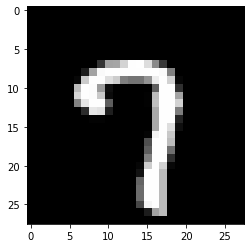

In [43]:
for images, labels in data_loader: 
    print(images.shape)
    x = denorm(images[0])
    print(x.shape)
    plt.imshow(x[0],cmap="gray")
    print(labels[0])
    break

## Using GPU

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
device

device(type='cuda')

## Discriminator Network

We will now create a discriminator network. It will take in images and tell us whether the image is real or generated. It is effectively a normal neural network and hence we can use 3 feed forward layers to make its model

In [46]:
import torch.nn as nn

In [47]:
# we set size of image 784 (28*28)
image_size = 784
hidden_size = 256

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

We use the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.  - [Source](https://sthalles.github.io/advanced_gans/)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being fake i.e. generated.

Sigmoid helps to bring our output from the final linear layer into 0-1 size. Hence making it like a probability answer. 

We can now move the model to our device

In [48]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## Generator Network

The use of the generator network is to create a vector of size 784(28*28) which can be used to convert it into a 28x28 image.

The input to the generator network will be a vector or matrix, it will serve as seed for generating images. 

As this also gives an output as a vector of size 784, we can make it by using 3 feed forward networks as well 

In [49]:
latent_size = 64
G  = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,784),
    nn.Tanh()
)

The tanh is the tan hyperbolic function. We know that range of tanh function is -1 to 1, what it effectively does is convert the inputs into outputs of range -1 to 1. 

In [50]:
?y.detach

Docstring:
Returns a new Tensor, detached from the current graph.

The result will never require gradient.

This method also affects forward mode AD gradients and the result will never
have forward mode AD gradients.

.. note::

  Returned Tensor shares the same storage with the original one.
  In-place modifications on either of them will be seen, and may trigger
  errors in correctness checks.
  IMPORTANT NOTE: Previously, in-place size / stride / storage changes
  (such as `resize_` / `resize_as_` / `set_` / `transpose_`) to the returned tensor
  also update the original tensor. Now, these in-place changes will not update the
  original tensor anymore, and will instead trigger an error.
  For sparse tensors:
  In-place indices / values changes (such as `zero_` / `copy_` / `add_`) to the
  returned tensor will not update the original tensor anymore, and will instead
  trigger an error.
Type:      builtin_function_or_method


In [51]:
# example GAN
y = G(torch.randn(2,latent_size)) # giving a random matrix as input
print(y.shape)
gen_img = denorm(y.reshape((-1,28,28)).detach())
print(gen_img.shape)

torch.Size([2, 784])
torch.Size([2, 28, 28])


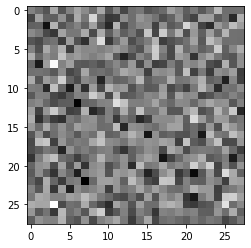

In [52]:
plt.imshow(gen_img[0], cmap='gray')

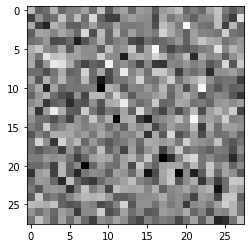

In [53]:
plt.imshow(gen_img[1], cmap='gray')


Moving generator model to device

In [54]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

## Discriminator Training

We will now be training the discriminator. We will firstly assign our loss function and optimizers. As our discriminator is a binary model we will hence be using a Binary Cross Entropy Loss function. 

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [55]:
criterion = nn.BCELoss() # Loss function 
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002) # discriminator optimizer
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002) # Generator Optimizer

We will also create functions to help us with training our models

In [56]:
def reset_grads():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [57]:
def train_discriminator(images): # images will be in vector of 784 form
    # creating real and fake labels. All real labels will be 1 and all fake labels will be 0 
    real_labels = torch.ones(batch_size,1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)
    
    # getting losses from real images
    outputs  = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs
    
    # getting losses from fake images 
    # creating fake images
    fake_input = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(fake_input)
    # checking losses against output
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    
    # total loss 
    d_loss = d_loss_real + d_loss_fake
    
    # reset grads and performing optimization 
    reset_grads()
    
    d_loss.backward()
    
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

## Generator Training 

As the generator gives us a an image as output. It is quite difficult to use it against a loss function to compute the loss. 

Instead what we do is we tend to check it against the discriminator itself. The discriminator gives a good idea of how real our images look. 

In [58]:
# test function to try. 
fake_images = G(torch.randn(batch_size,latent_size).to(device))
print(D(fake_images))

tensor([[0.4828],
        [0.4818],
        [0.4829],
        [0.4810],
        [0.4811],
        [0.4825],
        [0.4823],
        [0.4823],
        [0.4836],
        [0.4855],
        [0.4812],
        [0.4816],
        [0.4824],
        [0.4828],
        [0.4798],
        [0.4800],
        [0.4866],
        [0.4810],
        [0.4827],
        [0.4852],
        [0.4840],
        [0.4812],
        [0.4804],
        [0.4822],
        [0.4843],
        [0.4800],
        [0.4836],
        [0.4799],
        [0.4841],
        [0.4828],
        [0.4836],
        [0.4826],
        [0.4812],
        [0.4801],
        [0.4792],
        [0.4818],
        [0.4829],
        [0.4792],
        [0.4819],
        [0.4835],
        [0.4813],
        [0.4807],
        [0.4823],
        [0.4823],
        [0.4835],
        [0.4807],
        [0.4826],
        [0.4815],
        [0.4811],
        [0.4815],
        [0.4821],
        [0.4830],
        [0.4810],
        [0.4806],
        [0.4822],
        [0

Hence we can use the above approach to actually check our images.

In [59]:
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size,1).to(device)
    g_loss = criterion(D(fake_images), labels)
    
    # optimizing over losses
    reset_grads()
    g_loss.backward()
    g_optimizer.step()
    
    return g_loss, fake_images
    

## Saving Intermediate Images

We can store the intermediate outputs to check our progress. 

In [60]:
import os
from IPython.display import Image
from torchvision.utils import save_image 

In [61]:
# making the directory.
sample_dir = "samples"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

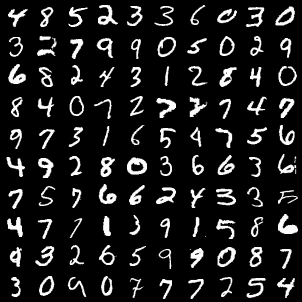

In [62]:
for images, _ in data_loader:
    images = images.reshape(images.size(0),1,28,28)
    save_image(denorm(images), os.path.join(sample_dir,'real_images.png'),nrow=10)
    break

Image(os.path.join(sample_dir,'real_images.png'))

To make batch of fake images after every iter let us make a function


In [63]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

In [64]:
def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0),1,28,28)
    fake_fname = "fake_images-"+str(index)+".png"
    save_image(denorm(fake_images),os.path.join(sample_dir, fake_fname),nrow=10)

In [65]:
# making a single initial fake batch
save_fake_images(0)

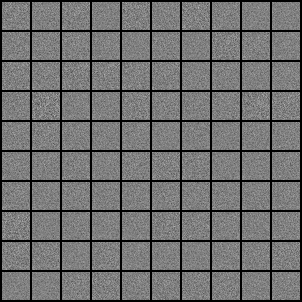

In [66]:
Image(os.path.join(sample_dir,'fake_images-0.png'))


In [67]:
%%time

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [],[],[],[]

for epoch in range(num_epochs):
    for i, (images,_) in enumerate(data_loader):
        # convert images to vector of size 784
        images = images.reshape(batch_size,-1).to(device)
        
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
        
    
    save_fake_images(epoch+1)

Epoch [0/50], Step [200/600], d_loss: 0.0447, g_loss: 3.9712, D(x): 0.99, D(G(z)): 0.04
Epoch [0/50], Step [400/600], d_loss: 0.0435, g_loss: 5.8285, D(x): 0.99, D(G(z)): 0.03
Epoch [0/50], Step [600/600], d_loss: 0.1113, g_loss: 4.9071, D(x): 0.98, D(G(z)): 0.08
Epoch [1/50], Step [200/600], d_loss: 0.0493, g_loss: 5.8600, D(x): 0.97, D(G(z)): 0.02
Epoch [1/50], Step [400/600], d_loss: 0.3240, g_loss: 4.3755, D(x): 0.86, D(G(z)): 0.05
Epoch [1/50], Step [600/600], d_loss: 0.1341, g_loss: 4.9530, D(x): 0.94, D(G(z)): 0.03
Epoch [2/50], Step [200/600], d_loss: 0.8175, g_loss: 2.5905, D(x): 0.71, D(G(z)): 0.12
Epoch [2/50], Step [400/600], d_loss: 0.2255, g_loss: 3.2606, D(x): 0.93, D(G(z)): 0.09
Epoch [2/50], Step [600/600], d_loss: 0.4626, g_loss: 3.8525, D(x): 0.80, D(G(z)): 0.10
Epoch [3/50], Step [200/600], d_loss: 0.4133, g_loss: 3.1621, D(x): 0.88, D(G(z)): 0.08
Epoch [3/50], Step [400/600], d_loss: 0.5860, g_loss: 2.4793, D(x): 0.82, D(G(z)): 0.25
Epoch [3/50], Step [600/600], d_

## Making Video and Plotting Lossses

In [71]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [72]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

d:\DS\DS-Learn\Week-6\gans_training.avi

Text(0.5, 1.0, 'Losses')

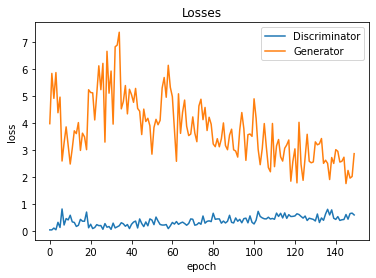

In [73]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

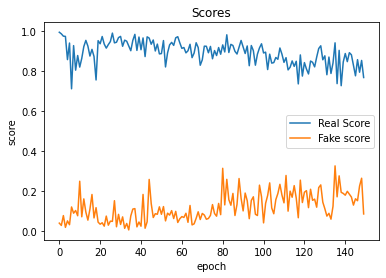

In [74]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');